In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from sklearn import model_selection
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook
from time import process_time


In [2]:
class FFSN_MultiClass:

    def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
        self.nx = n_inputs
        self.ny = n_outputs
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]

        self.W = {}
        self.B = {}
        for i in range(self.nh + 1):
            self.W[i + 1] = np.random.randn(self.sizes[i], self.sizes[i + 1])
            self.B[i + 1] = np.zeros((1, self.sizes[i + 1]))

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps)

    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i + 1]) + self.B[i + 1]
            self.H[i + 1] = self.sigmoid(self.A[i + 1])
        self.A[self.nh + 1] = np.matmul(self.H[self.nh], self.W[self.nh + 1]) + self.B[self.nh + 1]
        self.H[self.nh + 1] = self.softmax(self.A[self.nh + 1])
        return self.H[self.nh + 1]

    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

    def grad_sigmoid(self, x):
        return x * (1 - x)

    def cross_entropy(self, label, pred):
        yl = np.multiply(pred, label)
        yl = yl[yl != 0]
        yl = -np.log(yl)
        yl = np.mean(yl)
        return yl

    def grad(self, x, y):
        self.forward_pass(x)
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        L = self.nh + 1
        self.dA[L] = self.H[L] - y
        for k in range(L, 0, -1):
            self.dW[k] = np.matmul(self.H[k - 1].T, self.dA[k])
            self.dB[k] = self.dA[k]
            self.dH[k - 1] = np.matmul(self.dA[k], self.W[k].T)
            self.dA[k - 1] = np.multiply(self.dH[k - 1],
                    self.grad_sigmoid(self.H[k - 1]))

    def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
        if display_loss:
            loss = []
            time = []

        if initialize:
            for i in range(self.nh + 1):
                self.W[i + 1] = np.random.randn(self.sizes[i], self.sizes[i + 1])
                self.B[i + 1] = np.zeros((1, self.sizes[i + 1]))

        for epoch in tqdm_notebook(range(epochs), total=epochs,
                                   unit='epoch'):
#         for epoch in range(epochs):
            dW = {}
            dB = {}
            
            # Init gradien
            for i in range(self.nh + 1):
                dW[i + 1] = np.zeros((self.sizes[i], self.sizes[i + 1]))
                dB[i + 1] = np.zeros((1, self.sizes[i + 1]))
                
            for (x, y) in zip(X, Y):
                self.grad(x, y)
                for i in range(self.nh + 1):
                    dW[i + 1] += self.dW[i + 1]
                    dB[i + 1] += self.dB[i + 1]
                m = X.shape[1]
                for i in range(self.nh + 1):
                    self.W[i + 1] -= learning_rate * (dW[i + 1] / m)
                    self.B[i + 1] -= learning_rate * (dB[i + 1] / m)

            if display_loss:
                timer = process_time() - starttime
                time.append(timer)
                Y_pred = self.predict(X)
#                 loss[epoch] = self.cross_entropy(Y, Y_pred)
                loss.append(self.cross_entropy(Y, Y_pred))

        if display_loss:
#             print(loss)
            plt.plot(time, loss)
            plt.xlabel('Seconds')
            plt.ylabel('CE loss')     
            jangkau = max(x) - min(x)
            plt.yticks(np.arange(0, max(x)+ (jangkau*0.2), 0.2))
            plt.gcf().autofmt_xdate()
            plt.show()
            print("Training error",loss[-1])


# WINE

In [3]:
nFeatures = 13

data = pd.read_csv("data/wine - norm.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

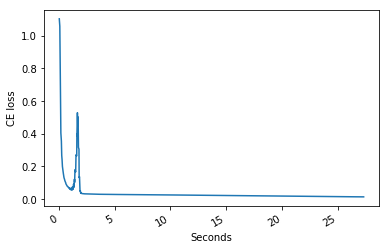

Training error 0.011478880048158387
Test error 0.038535550463807876
Test accuracy 0.9722222222222222


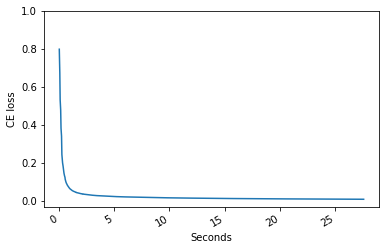

Training error 0.00675731921084387
Test error 0.04820221744705913
Test accuracy 0.9722222222222222


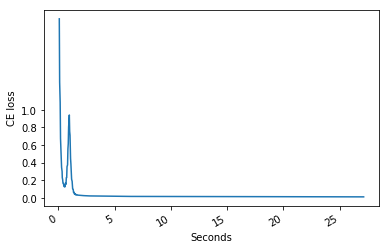

Training error 0.012210493073802058
Test error 0.006393663335018859
Test accuracy 1.0


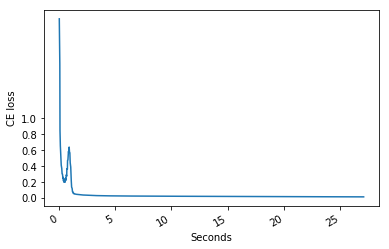

Training error 0.010263387927614836
Test error 0.0010403496326189465
Test accuracy 1.0


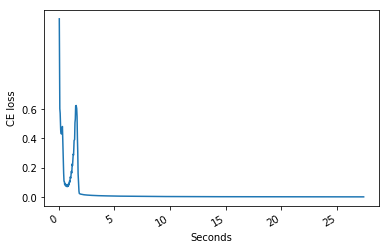

Training error 0.0011553837166536102
Test error 0.09637240409599782
Test accuracy 0.9714285714285714
Accuracy of model with cross validation : 0.9831746031746031


In [4]:

# nFeatures = 13

data = pd.read_csv("data/wine - norm.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

import time

n_input = 13
n_output = 3
hidden_layer = [10]
accuracy_test = []
n_splits = 5
ffsn_multi = FFSN_MultiClass(n_input, n_output, hidden_layer)

cv = model_selection.KFold(n_splits, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#         print("Train Index: ", train_index, "\n")
#         print("Test Index: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    starttime = process_time()
    ffsn_multi.fit(X_train,y_train,epochs=800, initialize = 'false',learning_rate=.01, display_loss=True)
    
    
#         print("Evaluating model...")
    y_test_preds = ffsn_multi.predict(X_test)
    test_error = ffsn_multi.cross_entropy(y_test, y_test_preds)
    print("Test error", test_error)
    
    y_test_preds = (y_test_preds >= 0.5).astype("int")
    
    score = accuracy_score(y_test_preds, y_test)
    print("Test accuracy",score)
    accuracy_test.append(score)
    
#     splitnow = splitnow + 1

#     print(accuracy_test)

print("Accuracy of model with cross validation :", mean(accuracy_test))


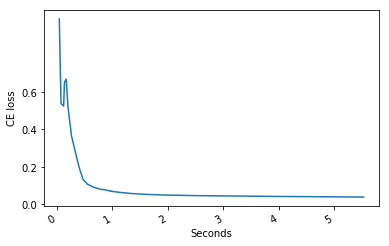

Training error 0.03909416419744113
Test error 0.08916702815665056
Test accuracy 0.9666666666666667


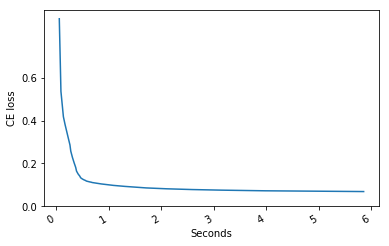

Training error 0.067404108553183
Test error 0.03986197548918649
Test accuracy 0.9666666666666667


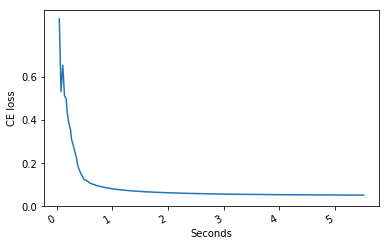

Training error 0.05025735795301141
Test error 0.07273690048702344
Test accuracy 0.9333333333333333


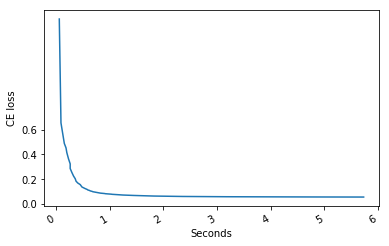

Training error 0.054016484602024024
Test error 0.03828843994597031
Test accuracy 0.9666666666666667


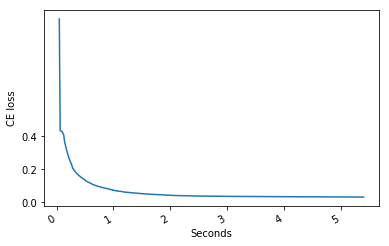

Training error 0.03225412646394217
Test error 0.14037570521423756
Test accuracy 0.9
Accuracy of model with cross validation : 0.9466666666666667


In [6]:

nFeatures = 4

data = pd.read_csv("data/iris-norm.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

import time

n_input = 4
n_output = 3
hidden_layer = [10]
accuracy_test = []
n_splits = 5
ffsn_multi = FFSN_MultiClass(n_input, n_output, hidden_layer)

cv = model_selection.KFold(n_splits, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#         print("Train Index: ", train_index, "\n")
#         print("Test Index: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    starttime = process_time()
    ffsn_multi.fit(X_train,y_train,epochs=200, initialize = 'false',learning_rate=.01, display_loss=True)
    
    
#         print("Evaluating model...")
    y_test_preds = ffsn_multi.predict(X_test)
    test_error = ffsn_multi.cross_entropy(y_test, y_test_preds)
    print("Test error", test_error)
    
    y_test_preds = (y_test_preds >= 0.5).astype("int")
    
    score = accuracy_score(y_test_preds, y_test)
    print("Test accuracy",score)
    accuracy_test.append(score)
    
#     splitnow = splitnow + 1

#     print(accuracy_test)

print("Accuracy of model with cross validation :", mean(accuracy_test))


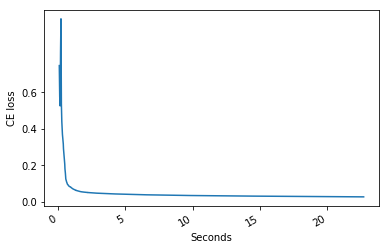

Training error 0.025637001429664942
Test error 0.1331703492043667
Test accuracy 0.9666666666666667


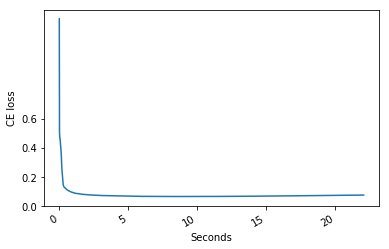

Training error 0.07380872924204976
Test error 0.09519865274174362
Test accuracy 0.9666666666666667


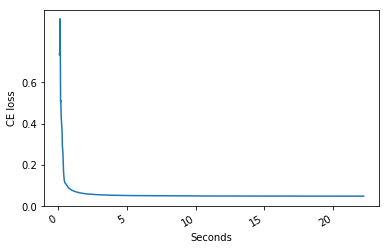

Training error 0.04689411391590524
Test error 0.05384957791638729
Test accuracy 0.9666666666666667


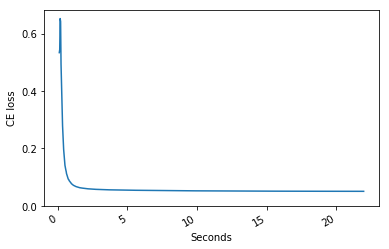

Training error 0.05034763275856005
Test error 0.02315826129499223
Test accuracy 1.0


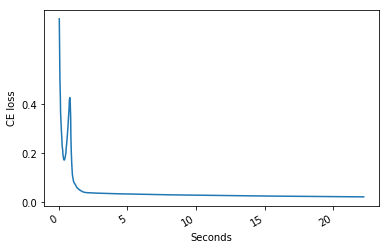

Training error 0.020550561505596792
Test error 0.356596814548571
Test accuracy 0.9
Accuracy of model with cross validation : 0.96


In [7]:

nFeatures = 4

data = pd.read_csv("data/iris-norm.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

import time

n_input = 4
n_output = 3
hidden_layer = [10]
accuracy_test = []
n_splits = 5
ffsn_multi = FFSN_MultiClass(n_input, n_output, hidden_layer)

cv = model_selection.KFold(n_splits, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#         print("Train Index: ", train_index, "\n")
#         print("Test Index: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    starttime = process_time()
    ffsn_multi.fit(X_train,y_train,epochs=800, initialize = 'false',learning_rate=.01, display_loss=True)
    
    
#         print("Evaluating model...")
    y_test_preds = ffsn_multi.predict(X_test)
    test_error = ffsn_multi.cross_entropy(y_test, y_test_preds)
    print("Test error", test_error)
    
    y_test_preds = (y_test_preds >= 0.5).astype("int")
    
    score = accuracy_score(y_test_preds, y_test)
    print("Test accuracy",score)
    accuracy_test.append(score)
    
#     splitnow = splitnow + 1

#     print(accuracy_test)

print("Accuracy of model with cross validation :", mean(accuracy_test))


In [13]:

nFeatures = 240

data = pd.read_csv("data/Geneesplice - Copy.csv", header=None)
data.astype('int64').dtypes
# print(data.dtypes)
array = data.values

X = array[:,0:nFeatures]
y = array[:,nFeatures:]
print (X, y)
print (X.shape , y.shape)
import time

n_input = nFeatures
n_output = 3
hidden_layer = [3]
accuracy_test = []
n_splits = 5


[[0 1 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]] [[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
(3190, 240) (3190, 3)


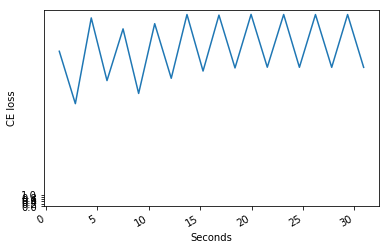

Training error 12.497377583940542
Test error 1.484522581641796
Test accuracy 0.0


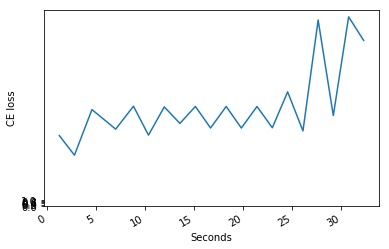

Training error 28.81135408732349
Test error 2.368752141007452
Test accuracy 0.7978056426332288


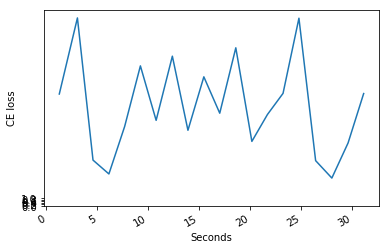

Training error 14.500230500899896
Test error 14.026915331641403
Test accuracy 0.4059561128526646


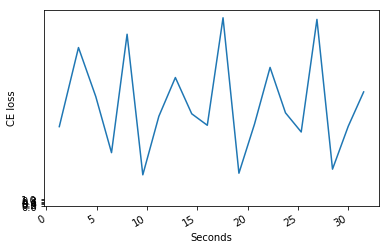

Training error 17.234899126902643
Test error 37.83594760781975
Test accuracy 0.0


In [ ]:
ffsn_multi = FFSN_MultiClass(n_input, n_output, hidden_layer)

cv = model_selection.KFold(n_splits, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#         print("Train Index: ", train_index, "\n")
#         print("Test Index: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    starttime = process_time()
    ffsn_multi.fit(X_train,y_train,epochs=20, initialize = 'false',learning_rate=.01, display_loss=True)
    
    
#         print("Evaluating model...")
    y_test_preds = ffsn_multi.predict(X_test)
#     print (y_test_preds)
    test_error = ffsn_multi.cross_entropy(y_test, y_test_preds)
    print("Test error", test_error)
    
    y_test_preds = (y_test_preds >= 0.5).astype("int")
#     print(y_test_preds, y_test)
#     np.argmax(y_test_pred, axis=1)
    
    score = accuracy_score(y_test_preds, y_test)
    print("Test accuracy",score)
    accuracy_test.append(score)
    
#     splitnow = splitnow + 1

#     print(accuracy_test)

print("Accuracy of model with cross validation :", mean(accuracy_test))


In [10]:
nFeatures = 21

data = pd.read_csv("data/annthyroid-train.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

import time

n_input = nFeatures
n_output = 3
hidden_layer = [3]
accuracy_test = []
n_splits = 5
print (X.shape, y.shape)

(3772, 21) (3772, 3)


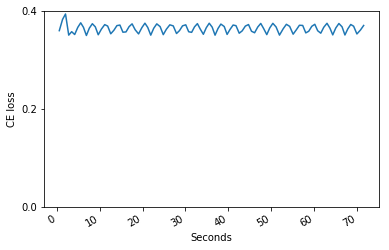

Training error 0.3704190847360014
Test error 0.2760111873542124
Test accuracy 0.9470198675496688


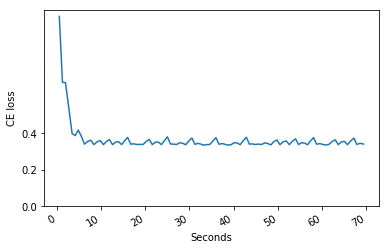

Training error 0.3410827943200945
Test error 0.3290868426476155
Test accuracy 0.9271523178807947


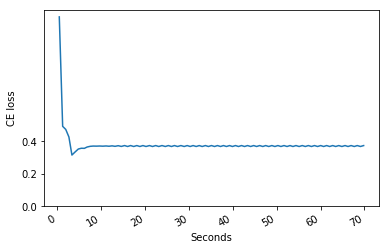

Training error 0.37337693452339027
Test error 0.4599731499779854
Test accuracy 0.9071618037135278


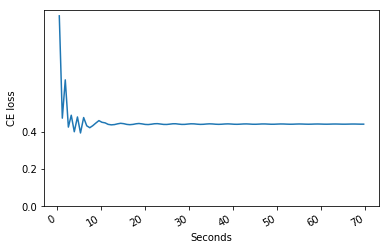

Training error 0.4406883275059632
Test error 0.4135225259109792
Test accuracy 0.9310344827586207


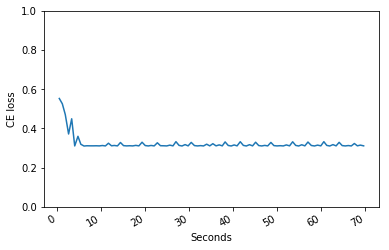

Training error 0.3113444038264559
Test error 0.3535997913331456
Test accuracy 0.9111405835543767
Accuracy of model with cross validation : 0.9247018110913977


In [12]:
ffsn_multi = FFSN_MultiClass(n_input, n_output, hidden_layer)

cv = model_selection.KFold(n_splits, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#         print("Train Index: ", train_index, "\n")
#         print("Test Index: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    starttime = process_time()
    ffsn_multi.fit(X_train,y_train,epochs=100, initialize = 'false',learning_rate=.01, display_loss=True)
    
    
#         print("Evaluating model...")
    y_test_preds = ffsn_multi.predict(X_test)
    test_error = ffsn_multi.cross_entropy(y_test, y_test_preds)
    print("Test error", test_error)
    
    y_test_preds = (y_test_preds >= 0.5).astype("int")
    
    score = accuracy_score(y_test_preds, y_test)
    print("Test accuracy",score)
    accuracy_test.append(score)
    
#     splitnow = splitnow + 1

#     print(accuracy_test)

print("Accuracy of model with cross validation :", mean(accuracy_test))